# <font color='#1EA8DB'>**Mall Customer Segmentation**</font> 

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset
df = pd.read_csv("Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
# Check number of rows and columns
df.shape

(200, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
# Create boolean Series for duplicate observations
duplicates = df.duplicated()

# Check if there are any duplicates
any_duplicates = duplicates.any()
print(f"Are there any duplicates? {any_duplicates}")

Are there any duplicates? False


We see that there are no missing values or duplicate observations in our data. We can therefore move on with our analysis.

In [6]:
# Check summary statistics of relevant numeric columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


In [7]:
# Check summary statistics of gender variable
df['Gender'].value_counts(normalize=True)

Gender
Female    0.56
Male      0.44
Name: proportion, dtype: float64

The mall has a wide range of customers in terms of age. They have customers as young as 18 and as old as 70 years. It is highly likely that the needs and spending patterns of the various age demographics will differ. There is also a wide range of income levels among the firm's customers, from $15k/year to $137k/year. Once again spending patterns and products of interest are likely to differ based on income levels.

We see also that the store has more female than male customers. The gender demographic may also be an angle to explore in our analysis.

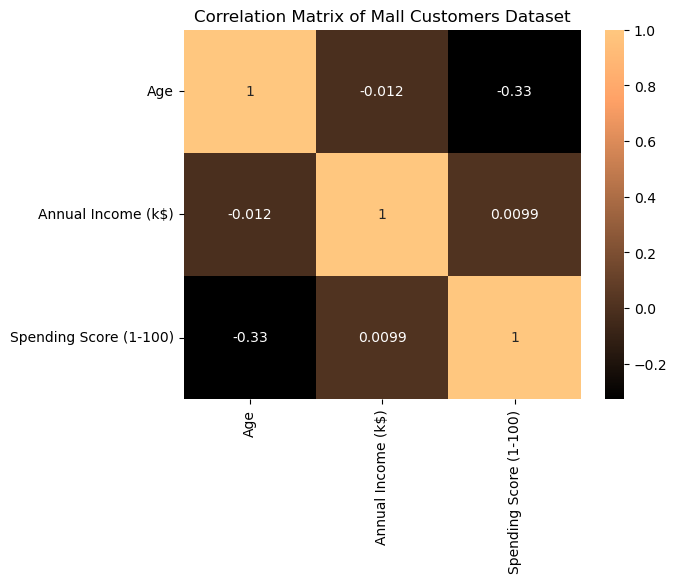

In [8]:
# Checking correlation numeric among variables
corr_df = df.drop(['CustomerID'], axis=1) # drop CustomerID variable

# Creating correlation matrix
corr = corr_df.corr(numeric_only=True)

sns.heatmap(corr, annot=True, cmap='copper')
plt.title('Correlation Matrix of Mall Customers Dataset')
plt.show()

There is a negative correlation between age and spending score, which gives some initial indication that that older customers tend to spend less. The correlation between income and age, and between income and spending score is very weak. It does not give any indication of an interesting relationship between these variables.

We will now explore how these numeric variables (`Age`, `Anuual Income`, `Spending Score`) differ by gender, which is the only categorical variable in the dataset.

In [9]:
# Check averages for numeric variables by gender
df.groupby('Gender')[['Age','Annual Income (k$)', 'Spending Score (1-100)']].mean()

,Age,Annual Income (k$),Spending Score (1-100)
Gender,,,
Female,38.098214,59.250000,51.526786
Male,39.806818,62.227273,48.511364


Male and female customers have approximately the same average age. However, male customers have higher incomes, while female customers tend to spend more.

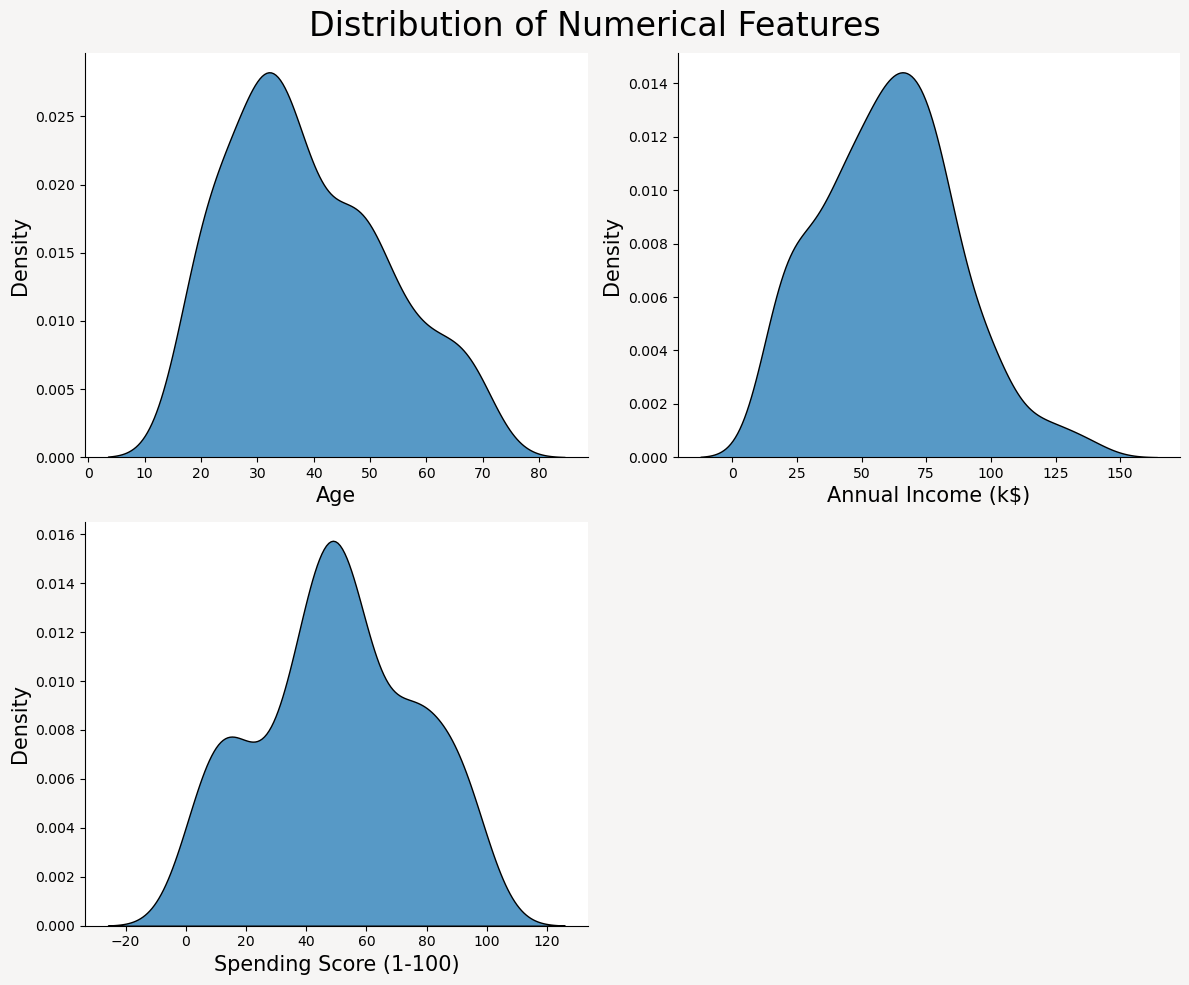

In [10]:
# Visualize distribution of numeric variables
feats = ['Age','Annual Income (k$)', 'Spending Score (1-100)']

L = len(feats)
ncol = 2
nrow = int(np.ceil(L / ncol))

fig, axs = plt.subplots(nrow, ncol, figsize=(12, 10), facecolor='#F6F5F4')
fig.subplots_adjust(top=0.97)

# Flatten the axs array for easy indexing
axs = axs.flatten()

for i, col in enumerate(feats):
    sns.kdeplot(data=df, x=col, multiple='stack', ax=axs[i])

    axs[i].set_xlabel(col, fontsize=15)
    axs[i].set_ylabel('Density', fontsize=15)
    sns.despine(right=True, ax=axs[i])

# Remove any unused axes if num_feats is odd
if L % 2 != 0:
    fig.delaxes(axs[-1])

plt.suptitle('Distribution of Numerical Features', fontsize=24)
plt.tight_layout()
plt.show()

## Modelling

In [11]:
# import required libraries
import plotly as py
import plotly.graph_objs as go
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)

### Segmentation Using Age and Spending Score

In [12]:
'''Age and spending Score'''
# Create an array of the values of `Age` and `Spending Score`
X1 = df[['Age' , 'Spending Score (1-100)']].iloc[: , :].values

# Create list to store inertia values
inertia = []

# Iterate over different values for n_clusters (the number of clusters)
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)

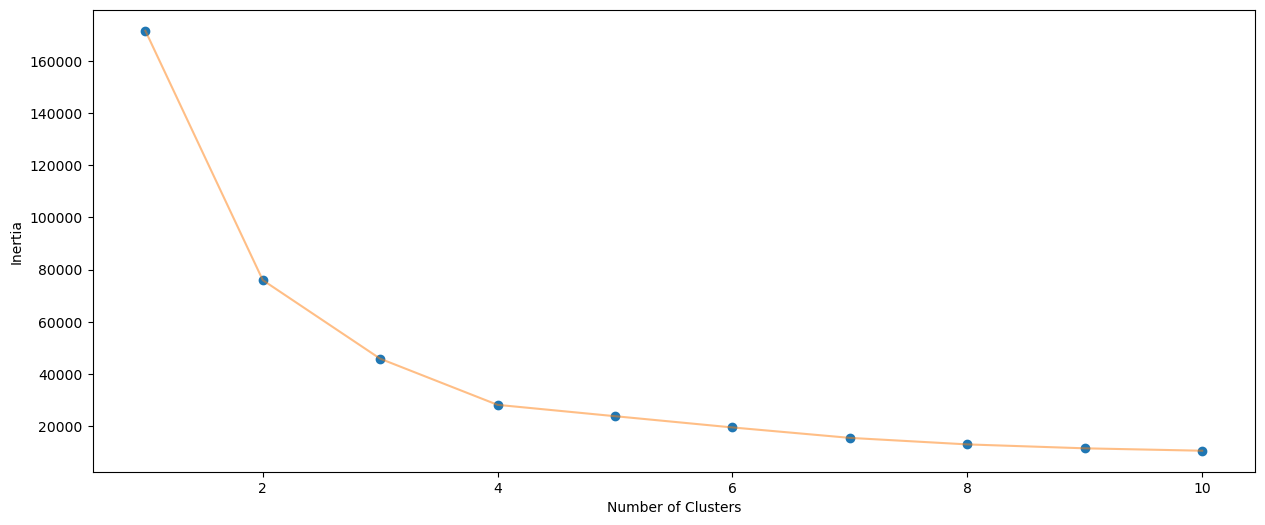

In [13]:
# Plot inertia for each value of n_clusters to select optimal k
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

The graph shows that 4 or 5 clusters will be appropriate for our model. We select $k=4$ and use this to create our clusters.

In [14]:
algorithm = (KMeans(n_clusters = 4 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X1)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

Text(0, 0.5, 'Spending Score (1-100)')

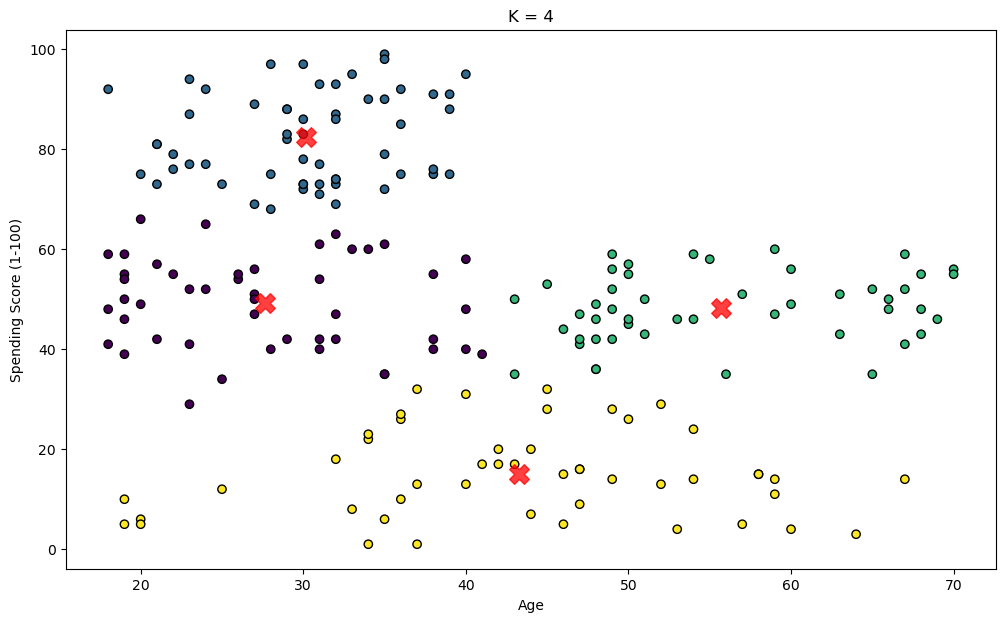

In [15]:
plt.figure(1 , figsize = (12, 7) )

# Scatter plot of the data points colored by labels
plt.scatter(x = 'Age', y = 'Spending Score (1-100)', data = df, c=labels1, 
            cmap='viridis', marker='o', edgecolor='k')
    
# Plot the centroids
plt.scatter(centroids1[:, 0], centroids1[:, 1], c='red', s=200, alpha=0.75, marker='X')
    
# Adding titles and labels
plt.title('K = 4')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')


The graph confirms what we saw in the correlation matrix. We see that younger customers (between 18 and 40 years old) have the highest spending scores. The mall can therefore focus advertising spending on this group of customers and conduct further research into what items younger customers usually purchase. This will help to increase sales revenue.

In [16]:
# Evaluate
silhouette = silhouette_score(X1, labels1)
davies_bouldin = davies_bouldin_score(X1, labels1)
calinski_harabasz = calinski_harabasz_score(X1, labels1)

print("Silhouette Score: ", silhouette)
print("Davies-Bouldin Score: ", davies_bouldin)
print("Calinski-Harabasz Index: ", calinski_harabasz)

Silhouette Score:  0.49973941540141753
Davies-Bouldin Score:  0.6869328339833629
Calinski-Harabasz Index:  332.56312684433055


### Segmentation using  Annual Income and Spending Score

In [17]:
'''Annual Income and spending Score'''
X2 = df[['Annual Income (k$)' , 'Spending Score (1-100)']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X2)
    inertia.append(algorithm.inertia_)

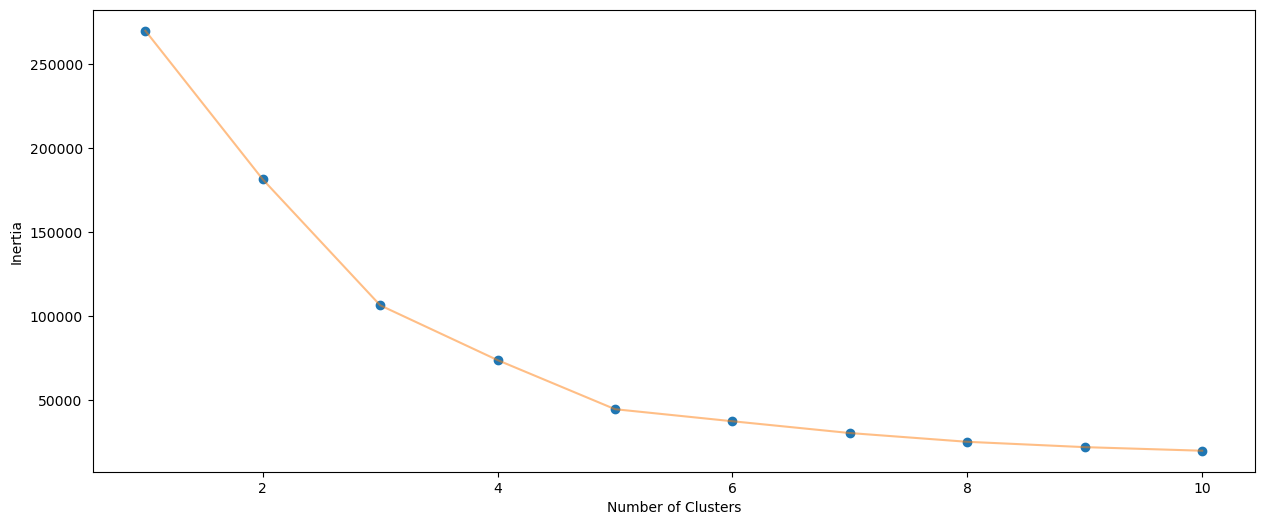

In [18]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

The graph shows that 5 or 6 clusters will be appropriate for our model. We select $k=5$ and use this to create our clusters.

In [19]:
algorithm = (KMeans(n_clusters = 5 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X2)
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

Text(0, 0.5, 'Spending Score (1-100)')

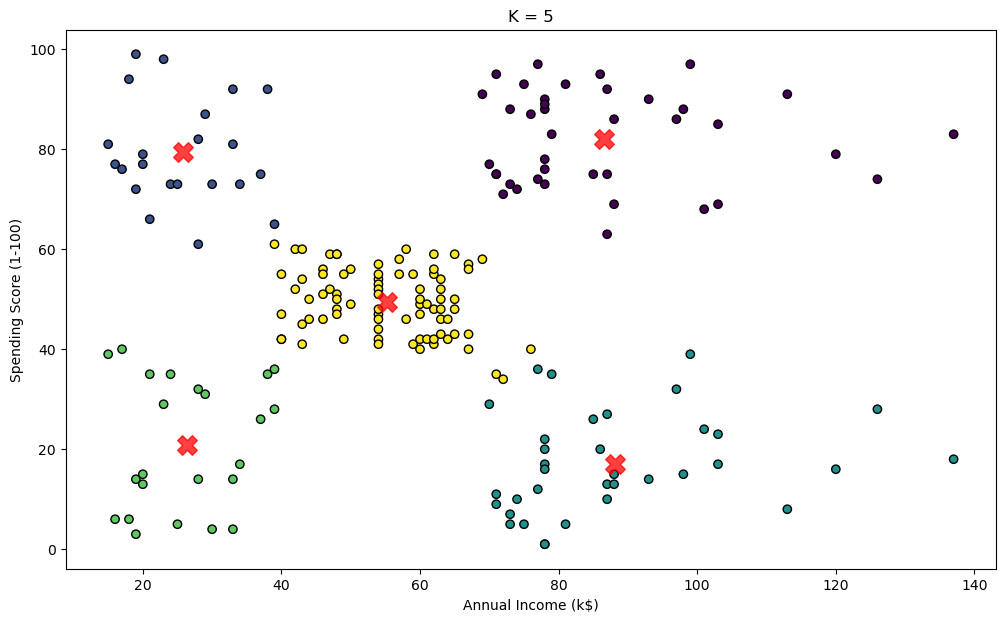

In [20]:
plt.figure(1 , figsize = (12, 7) )

# Scatter plot of the data points colored by labels
plt.scatter(x = 'Annual Income (k$)', y = 'Spending Score (1-100)', data = df, c=labels2, 
            cmap='viridis', marker='o', edgecolor='k')
    
# Plot the centroids
plt.scatter(centroids2[:, 0], centroids2[:, 1], c='red', s=200, alpha=0.75, marker='X')
    
# Adding titles and labels
plt.title('K = 5')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

The graph shows two distinct high-spending clusters: one among low-income customers with between $20k-$40k in annual income, and the other among high-income customers with between $70k-$140k in annual income. Customers from these same income groups have the lowest spending scores also.

In [21]:
# Evaluate
silhouette = silhouette_score(X2, labels2)
davies_bouldin = davies_bouldin_score(X2, labels2)
calinski_harabasz = calinski_harabasz_score(X2, labels2)

print("Silhouette Score: ", silhouette)
print("Davies-Bouldin Score: ", davies_bouldin)
print("Calinski-Harabasz Index: ", calinski_harabasz)

Silhouette Score:  0.553931997444648
Davies-Bouldin Score:  0.5725628995597086
Calinski-Harabasz Index:  247.3589933803728


### Segmentation using Age , Annual Income and Spending Score

In [22]:
X3 = df[['Age' , 'Annual Income (k$)' ,'Spending Score (1-100)']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X3)
    inertia.append(algorithm.inertia_)

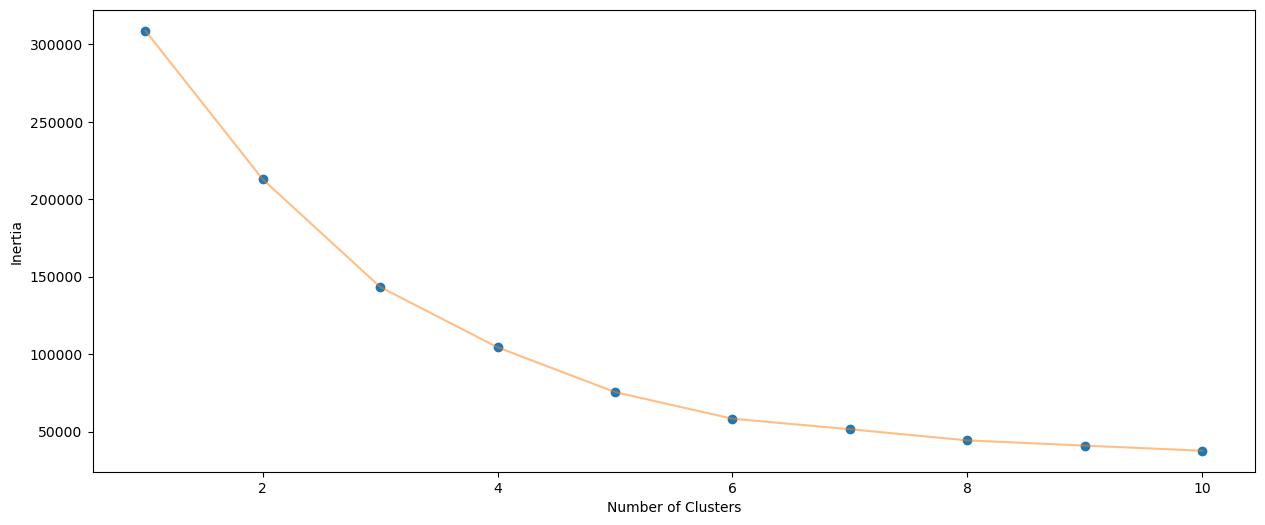

In [23]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

The graph shows that 6 or 7 clusters will be appropriate for our model. We select $k=6$ and use this to create our clusters.

In [24]:
algorithm = (KMeans(n_clusters = 6 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X3)
labels3 = algorithm.labels_
centroids3 = algorithm.cluster_centers_

In [25]:
df['label3'] =  labels3
trace1 = go.Scatter3d(
    x= df['Age'],
    y= df['Spending Score (1-100)'],
    z= df['Annual Income (k$)'],
    mode='markers',
     marker=dict(
        color = df['label3'], 
        size= 20,
        line=dict(
            color= df['label3'],
            width= 12
        ),
        opacity=0.8
     )
)
data = [trace1]
layout = go.Layout(
     height=700,
     margin=dict(
         l=20,
         r=20,
         b=20,
         t=20
     ),
     title={
        'text': 'Customer Clusters with Age, Spending Score, and Annual Income',
        'y':0.95,
        'x':0.5,
        'yanchor': 'top'},
    scene = dict(
            xaxis = dict(title  = 'Age'),
            yaxis = dict(title  = 'Spending Score'),
            zaxis = dict(title  = 'Annual Income')
        )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

Examining the figure from a 2D perspective, we see the pattern of the previous model, where we had `high-income-high spending`, `low-income-high spending`, `high-income-low spending`, and `low-income-low spending` clusters. Adding the age dimension gives more clarity. We see that the high-spending groups in both high- and low-income categories are generally younger (between 20 and 40 years old). This ties in with the clusters we saw in the initial `Age`-`Spending Score` clusters. 

A possible conclusion from this is that the mall needs to focus its advertising and promotions on younger customers.

In [26]:
# Evaluate
silhouette = silhouette_score(X3, labels3)
davies_bouldin = davies_bouldin_score(X3, labels3)
calinski_harabasz = calinski_harabasz_score(X3, labels3)

print("Silhouette Score: ", silhouette)
print("Davies-Bouldin Score: ", davies_bouldin)
print("Calinski-Harabasz Index: ", calinski_harabasz)

Silhouette Score:  0.4523443947724053
Davies-Bouldin Score:  0.7469740072755283
Calinski-Harabasz Index:  166.72049317886865


### Model Performance Evaluation

**Silhouette Score**

The `Age`-`Spending Score` model with 4 clusters has a silhouette score of 0.4997, the `Annual Income`-`Spending Score` model with 5 clusters has a score of 0.5539, and the `Age`-`Annual Income`-`Spending Score` model with 6 clusters has a score of 0.4523. Since a higher silhouette score indicates better clustering, based on the silhouette score, the model with the best clustering is the `Annual Income`-`Spending Score` model, followed by the `Age`-`Spending Score` model.
</br>
</br>

**Davies-Bouldin Index**

The `Age`-`Spending Score` model with 4 clusters has a Davies-Bouldin Index value of 0.6869, the `Annual Income`-`Spending Score` model with 5 clusters has a value of 0.5626, and the `Age`-`Annual Income`-`Spending Score` model with 6 clusters has a score of 0.7470. Since a lower Davies-Bouldin Index indicates better clustering, the model with the best clustering in this case is still the `Annual Income`-`Spending Score` model, followed by the `Age`-`Spending Score` model.
</br>
</br>

**Calinski-Harabasz Index (Variance Ratio Criterion)**

The `Age`-`Spending Score` model with 4 clusters has a Calinski-Harabasz Index value of 332.5621, the `Annual Income`-`Spending Score` model with 5 clusters has a value of 247.3590, and the `Age`-`Annual Income`-`Spending Score` model with 6 clusters has a score of 166.7205. Based on this index Since a lower Davies-Bouldin Index indicates better clustering, the best performing model is the `Age`-`Spending Score` model, followed by the `Annual Income`-`Spending Score` model.